In [1]:
develop_run=False # Set to true if the notebook is tested instead of fully executed
import sys,os
sys.path.append(os.getcwd()) # We assume the file is in the same directory as the notebook
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# import leafmap
import xarray as xr
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from rasterio import RasterioIOError
import requests

In [2]:
EVENT_NAME = 'monkey_creek_fire_2024'
EVENT_NAME = 'chile_fire_2024'
EVENT_NAME = 'park_fire_2024'

In [3]:
yaml_file = f'marshak/L_ad_hoc_data_generation/events/{EVENT_NAME}.yml'
# yaml_file = f'events/{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'park_fire_2024',
 'bounds': [-122.063588, 39.770975, -121.49483901, 40.394684],
 'event_date': '2024-07-24',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [137, 115],
 'mgrs_tiles': ['10TEK', '10TFK'],
 'dist_hls_confirmed_change_min_days': 15,
 'source_id': 'WFIGS Park Fire 2024',
 'links': ['https://en.wikipedia.org/wiki/Park_Fire']}

In [4]:
track_number = event_dict['rtc_track_numbers'][0]

In [7]:
polarizations = ['VV', 'VH']
scale_type = 'db'
forest_mask_enabled = 'False'

In [6]:
merged_dir = f'out/{EVENT_NAME}/rtc_ts_merged/track{track_number}'

In [8]:
da_stack = []


for polarization in polarizations:
    polarization_stack = []
    file_path_list = glob.glob(f'{merged_dir}/*{polarization}.tif')

    for file_path in file_path_list:
        filename = file_path.split('/')[-1]
        time = pd.to_datetime(filename.split('_')[1])  
        
        # Read the GeoTIFF file using xarray
        da = xr.open_dataarray(file_path, engine="rasterio")
        
        # Apply conversion if the scale type is 'db'
        if scale_type == 'db':
            da = 10 * np.log10(da.where(da > 0))  # Convert to dB scale, avoid log of zero or negative values
            print(f"Converted {filename} to dB scale.")
        else:
            print(f"Keeping {filename} in linear scale.")
        
        # Expand the 'time' dimension
        da = da.expand_dims(time=pd.Index([time], name='time'))
        
        polarization_stack.append(da)
    
    # Concatenate along 'time' dimension, creating a separate DataArray for each polarization
    da_polarized = xr.concat(polarization_stack, dim='time')
    
    # Add 'polarization' dimension as well
    da_polarized = da_polarized.expand_dims(polarization=pd.Index([polarization], name='polarization'))
    
    da_stack.append(da_polarized)

# Concatenate all the polarizations along the 'polarization' dimension
ds = xr.concat(da_stack, dim='polarization')


Converted merged_2024-04-25_track137_VV.tif to dB scale.
Converted merged_2024-05-07_track137_VV.tif to dB scale.
Converted merged_2024-05-19_track137_VV.tif to dB scale.
Converted merged_2024-05-31_track137_VV.tif to dB scale.
Converted merged_2024-06-12_track137_VV.tif to dB scale.
Converted merged_2024-07-06_track137_VV.tif to dB scale.
Converted merged_2024-07-18_track137_VV.tif to dB scale.
Converted merged_2024-07-30_track137_VV.tif to dB scale.
Converted merged_2024-08-11_track137_VV.tif to dB scale.
Converted merged_2024-08-23_track137_VV.tif to dB scale.
Converted merged_2024-09-04_track137_VV.tif to dB scale.
Converted merged_2024-09-16_track137_VV.tif to dB scale.
Converted merged_2024-04-25_track137_VH.tif to dB scale.
Converted merged_2024-05-07_track137_VH.tif to dB scale.
Converted merged_2024-05-19_track137_VH.tif to dB scale.
Converted merged_2024-05-31_track137_VH.tif to dB scale.
Converted merged_2024-06-12_track137_VH.tif to dB scale.
Converted merged_2024-07-06_tra

In [9]:
##########################################################################
# Default stretch boundaries for SAR power data 
##########################################################################
dclim={
    'vv':(0.01,0.1),
    'vh':(0.005,0.03)
    }  

In [10]:
##########################################################################
# Detect polarization from name and set clim
##########################################################################
polarization = 'vv'
clim=dclim[polarization]
print('Processing polarization',polarization, clim)


Processing polarization vv (0.01, 0.1)


[back to TOC](#TOC)

<a id="SEC_4B"></a>
### Generate a forest mask for a baseline period 

For a baseline period we generate a crude forest mask to by thresholding the minimum backscatter of the time series of the baseline period.

1. Subset the time series stack to the baseline period
2. Compute the minimum backscatter image in the time series
3. Threshold the minimum backscatter image. Options:
    - Use -20 dB as a viable global threshold
    - visual analysis of the minimum image or 
    - in an automated fashion based on histogram analysis with existing landcover classifiations. 
4. Apply the threshold to the entire time series stack for analysis with Cumulative Sum analysis

#### 1. Subset the time series stack to the baseline period

We define the year 2020 as the baseline year and look for disturbances in the years 2021 and 2022.

In [10]:
import datetime
event_date = datetime.datetime.strptime(event_dict['event_date'], '%Y-%m-%d')

# Subtract 'pre_event_window_days' from the event date
pre_event_startdate = event_date - datetime.timedelta(days=event_dict['pre_event_window_days'])
pre_event_enddate = event_date - datetime.timedelta(days=1)
da_pre_event = ds.sel(time=slice(pre_event_startdate, pre_event_enddate))
da_pre_event

<xarray.DataArray 'band_data' (polarization: 2, time: 7, band: 1, y: 3660,
                               x: 6994)> Size: 1GB
array([[[[[        nan,         nan,         nan, ..., -10.443819 ,
           -10.67893  , -10.891542 ],
          [        nan,         nan,         nan, ..., -10.589972 ,
           -10.777763 , -10.920633 ],
          [        nan,         nan,         nan, ..., -10.724045 ,
           -11.211884 , -11.219226 ],
          ...,
          [        nan,         nan,         nan, ...,  -8.18493  ,
            -8.178769 ,  -8.206924 ],
          [        nan,         nan,         nan, ...,  -8.236562 ,
            -8.256164 ,  -8.249964 ],
          [        nan,         nan,         nan, ...,  -8.234044 ,
            -8.243627 ,  -8.235849 ]]],


        [[[        nan,         nan,         nan, ..., -10.410587 ,
           -10.5918255, -11.028704 ],
          [        nan,         nan,         nan, ..., -10.479299 ,
           -10.7680435, -10.933934 ],
          [        nan,         nan,         nan, ..., -10.692623 ,
...
           -11.866895 , -11.872843 ],
          [        nan,         nan,         nan, ..., -11.915352 ,
           -11.929549 , -11.922254 ],
          [        nan,         nan,         nan, ..., -11.962895 ,
           -11.884527 , -11.893929 ]]],


        [[[        nan,         nan,         nan, ..., -18.407131 ,
           -17.59845  , -17.277567 ],
          [        nan,         nan,         nan, ..., -18.65148  ,
           -17.984146 , -17.325247 ],
          [        nan,         nan,         nan, ..., -18.644245 ,
           -18.411963 , -17.264658 ],
          ...,
          [        nan,         nan,         nan, ..., -12.278867 ,
           -12.252043 , -12.256598 ],
          [        nan,         nan,         nan, ..., -12.156841 ,
           -12.270342 , -12.248926 ],
          [        nan,         nan,         nan, ..., -12.063969 ,
           -12.03025  , -12.28326  ]]]]], dtype=float32)
Coordinates:
  * polarization  (polarization) object 16B 'VV' 'VH'
  * time          (time) datetime64[ns] 56B 2024-04-25 2024-05-07 ... 2024-07-18
  * band          (band) int64 8B 1
  * x             (x) float64 56kB 5e+05 5e+05 5.001e+05 ... 7.098e+05 7.098e+05
  * y             (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref   int64 8B 0

#### 2. Compute the minimum backscatter image in the time series

In a first step, we are computing the minimum backscatter per pixel in the reference pariod.

In [11]:
da_min=da_pre_event.min('time')


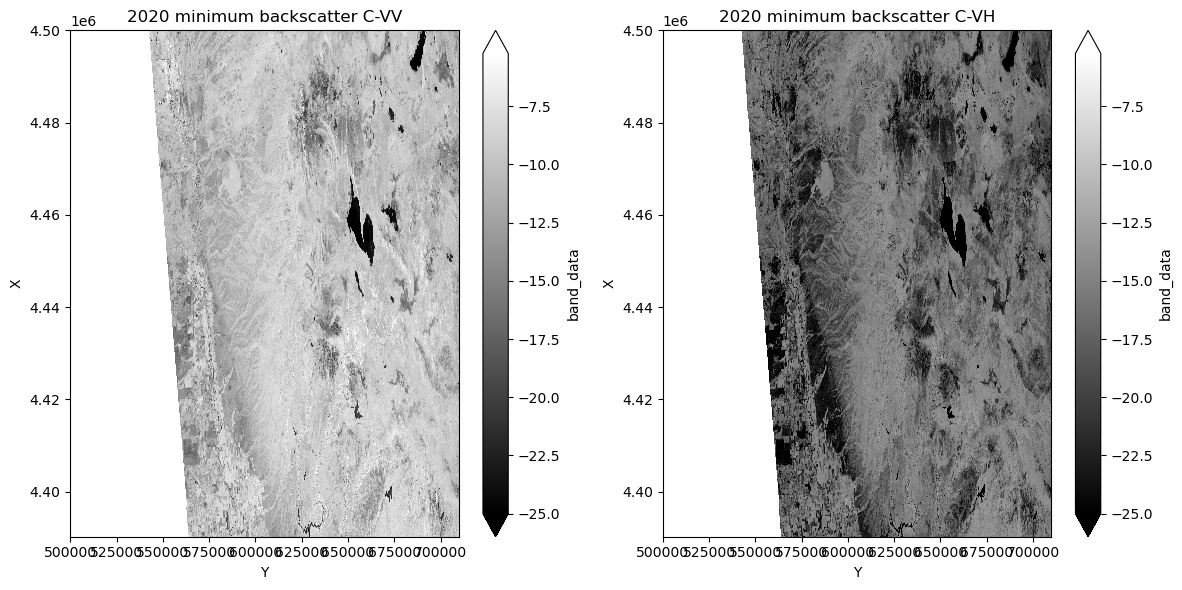

In [17]:
try:
    da_min.close()
    del da_min
except:
    pass
clim=(0, 0.01)

norm = plt.Normalize(0, 0.3)

if scale_type == 'db':
    norm = plt.Normalize(-25, 10 * np.log10(0.3))
    
# Create subplots for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot VV polarization
da_min_vv = da_pre_event.min('time').sel(polarization='VV')
da_min_vv.plot(ax=ax1, x='x', y='y', cmap='gray', norm=norm)
ax1.set_title('2020 minimum backscatter C-VV')
ax1.set_xlabel('Y')
ax1.set_ylabel('X')

# Plot VH polarization
da_min_vh = da_pre_event.min('time').sel(polarization='VH')
da_min_vh.plot(ax=ax2, x='x', y='y', cmap='gray', norm=norm)
ax2.set_title('2020 minimum backscatter C-VH')
ax2.set_xlabel('Y')
ax2.set_ylabel('X')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


<a id="FIG_5"></a>

Figure 5: Minumum backscatter at each pixel in the reference year in L-HV polarization (right). Data are power scaled. As can be seen, some burst pattern and subswath banding is present in this dataset. Time series backscatter (left).

#### 3. Threshold the minimum backscatter image

The next step is thresholding the minimum backscatter image in order to generate a crude forest mask. As threshold we are choosing -20 dB (0.01).

-20.969100130080562


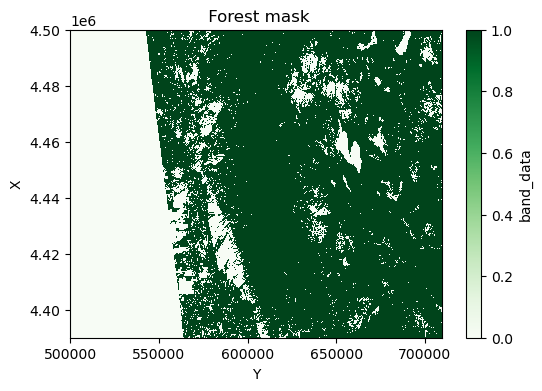

In [20]:
thres=0.008 # -20 dB
if scale_type == 'db':
    thres = 10 * np.log10(thres)
print(thres)

da_min_vh = da_pre_event.min('time').sel(polarization='VH')
fmask = (da_min_vh > thres).persist()

fig, ax = plt.subplots(figsize=(6, 4))
fmask.plot(ax=ax, x='x', y='y', cmap='Greens')
ax.set_title(' Forest mask')
ax.set_xlabel('Y')
ax.set_ylabel('X')

plt.show()

Figure 6: Forest mask in the reference period derived from thresholding the year 2020 minimum image at -20 dB. Zoomed out it looks as if the threshold keeps way to much forest, but zoomed in one sees a good separation of forest-non-forest in the baseline image.

In [21]:
##########################################################################
# Apply the forest mask to the entire data stack
##########################################################################
ds_masked=ds.where(fmask==1)   

In [22]:
lastdate = str(ds_masked.time[-1].values).split('T')[0]
tmpdates = ds_masked.time.copy()
# ds_masked = ds_masked.rename({'time':'Date'})


[back to TOC](#TOC)

<a id="SEC_4C"></a>
### 4.C Check for seasonality
Within the masked subset we pick another subset where no deforestation took place (as per visual inspection) to test for seasonality affects on backscatter variation. For the check we group the time series by months and computed medians along the time axis and then a spatial mean on these medians. During operations, this will be an automated process based on statistics of a larger region (e.g. entire tile or NISAR frame) where the relatively small fraction of disturbed areas would be statistically insignificant. We determine that seasonality should be addressed if the found minima and maxima of backscatter exceed a variation of 1 dB. 

<a id="FIG_10"></a>

In [24]:
monthly_means_vh = ds_masked.groupby('time.month').mean(dim=['time','x','y']).sel(polarization='VH')
monthly_means_vv = ds_masked.groupby('time.month').mean(dim=['time','x','y']).sel(polarization='VV')

In [30]:
# ds_masked_sub.hvplot.image(x='x',y='y',geo=True,rasterize=True,cmap='gray',frame_width=600,clim=(0.001,0.05),widgets={'time':pn.widgets.Select})

Text(0, 0.5, 'Pixel Value')

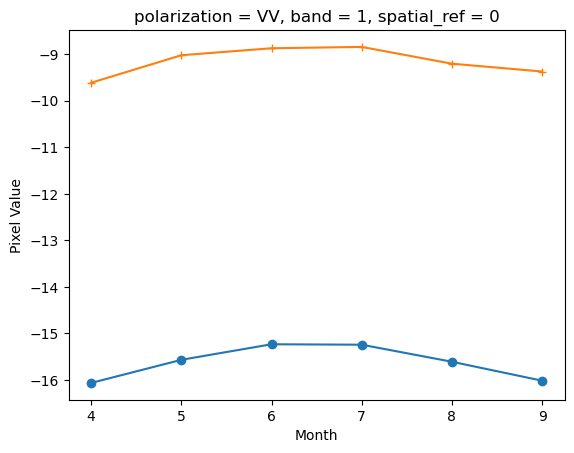

In [25]:
ylabel=r"\[\ \gamma^0 [dB] \]"
xlabel='Month'
if scale_type == 'db':
    monthly_means_vh.plot(marker='o', linestyle='-', label='VH') 
    monthly_means_vv.plot(marker='+', linestyle='-', label='VV') 
else:
    (10*np.log10(monthly_means_vh)).plot(marker='o', linestyle='-', label='VH') 
    (10*np.log10(monthly_means_vv)).plot(marker='+', linestyle='-', label='VV') 
plt.xlabel('Month')
plt.ylabel('Pixel Value')
#ylabel=ylabel,xlabel=xlabel,title='Monthly backscatter means over forest',dynamic=False)

Figure 10: Monthly backscatter means over forest in the data stack. We can see the dry (July to October) and wet (December to May) season months. The overall variation in the forested section here  is on the order of 0.5 dB.

Since we are not exceeding the threshold of 1 dB in annual backscatter variation over forest, we will use the entire time series for further analysis.

[back to TOC](#TOC)

<a id="SEC_4D"></a>
### 4.D Change point detection with cumulative sum analysis



Let $X$ be the time series of the subset of n selected scenes as

\begin{align}
    X = (X_1,X_2,...,X_n) \label{eq7.}\tag{7.}
\end{align}

with

- $X_i$  SAR backscatter at time $i=1,...,n$
- $n$ number of observations in the time series

In [26]:
X = ds_masked

#### Single Point time series visualizations of mid and late disturbance events
Before we analyze the entire image subset, we explore  the time series X, its Residuals against the geometric mean between max(X) and min(X) , and the corresponding S Curve for disturbance events at times in the middle and late dates of the time series. For this we pick locations in the subset that can be found via the visualization tool above.

In [27]:
def single_point_CP_vis(Xpoint, x, y, polarization='hv'):
    print('here')
    X = Xpoint.sel(x=x, y=y, method='nearest').sel(polarization=polarization)
    Xmean_maxmin = (X.max(dim='time') + X.min(dim='time')) / 2
    R = X - Xmean_maxmin
    Rm = X - X.mean()

    S = R.cumsum(dim='time')
    Sm = Rm.cumsum(dim='time')
    CP = S.time.isel(time=S.argmax('time')).values

    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    # Plot the original data
    axes[0].plot(X.time, X, label='gamma0')
    axes[0].axhline(float(Xmean_maxmin.values), color='red', label='min(X)+(max(X)-min(X))/2')
    axes[0].axhline(float(X.mean().values), color='gray', linestyle='dashed', label='Mean')
    axes[0].set_title(f'Backscatter {polarization}')
    axes[0].legend()

    # Plot the residuals
    axes[1].plot(R.time, R, label='Residuals')
    axes[1].plot(Rm.time, Rm, color='gray', linestyle='dashed', label='Residuals Mean')
    axes[1].axhline(0, color='red')
    axes[1].axvline(CP, color='black')
    axes[1].set_title('Residuals')
    axes[1].legend()

    # Plot the cumulative sums
    axes[2].plot(S.time, S, label='S Curve (Cumulative Sums)')
    axes[2].plot(Sm.time, Sm, color='gray', linestyle='dashed', label='S Curve Mean')
    axes[2].axvline(CP, color='black')
    axes[2].set_title('S Curve (Cumulative Sums)')
    axes[2].legend()

    fig.suptitle(f'Time Series of Sentinel-1 Observations at Lon/lat {x}/{y}')
    plt.tight_layout()
    plt.show()

<a id="FIG_11"></a>

In [28]:
print(np.nanmin(X['x'].values), np.nanmax(X['x'].values))
print(np.nanmin(X['y'].values), np.nanmax(X['y'].values))

499995.0 709785.0
4390215.0 4499985.0


here


/tmp/ipykernel_196874/937456285.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[0].axhline(float(Xmean_maxmin.values), color='red', label='min(X)+(max(X)-min(X))/2')


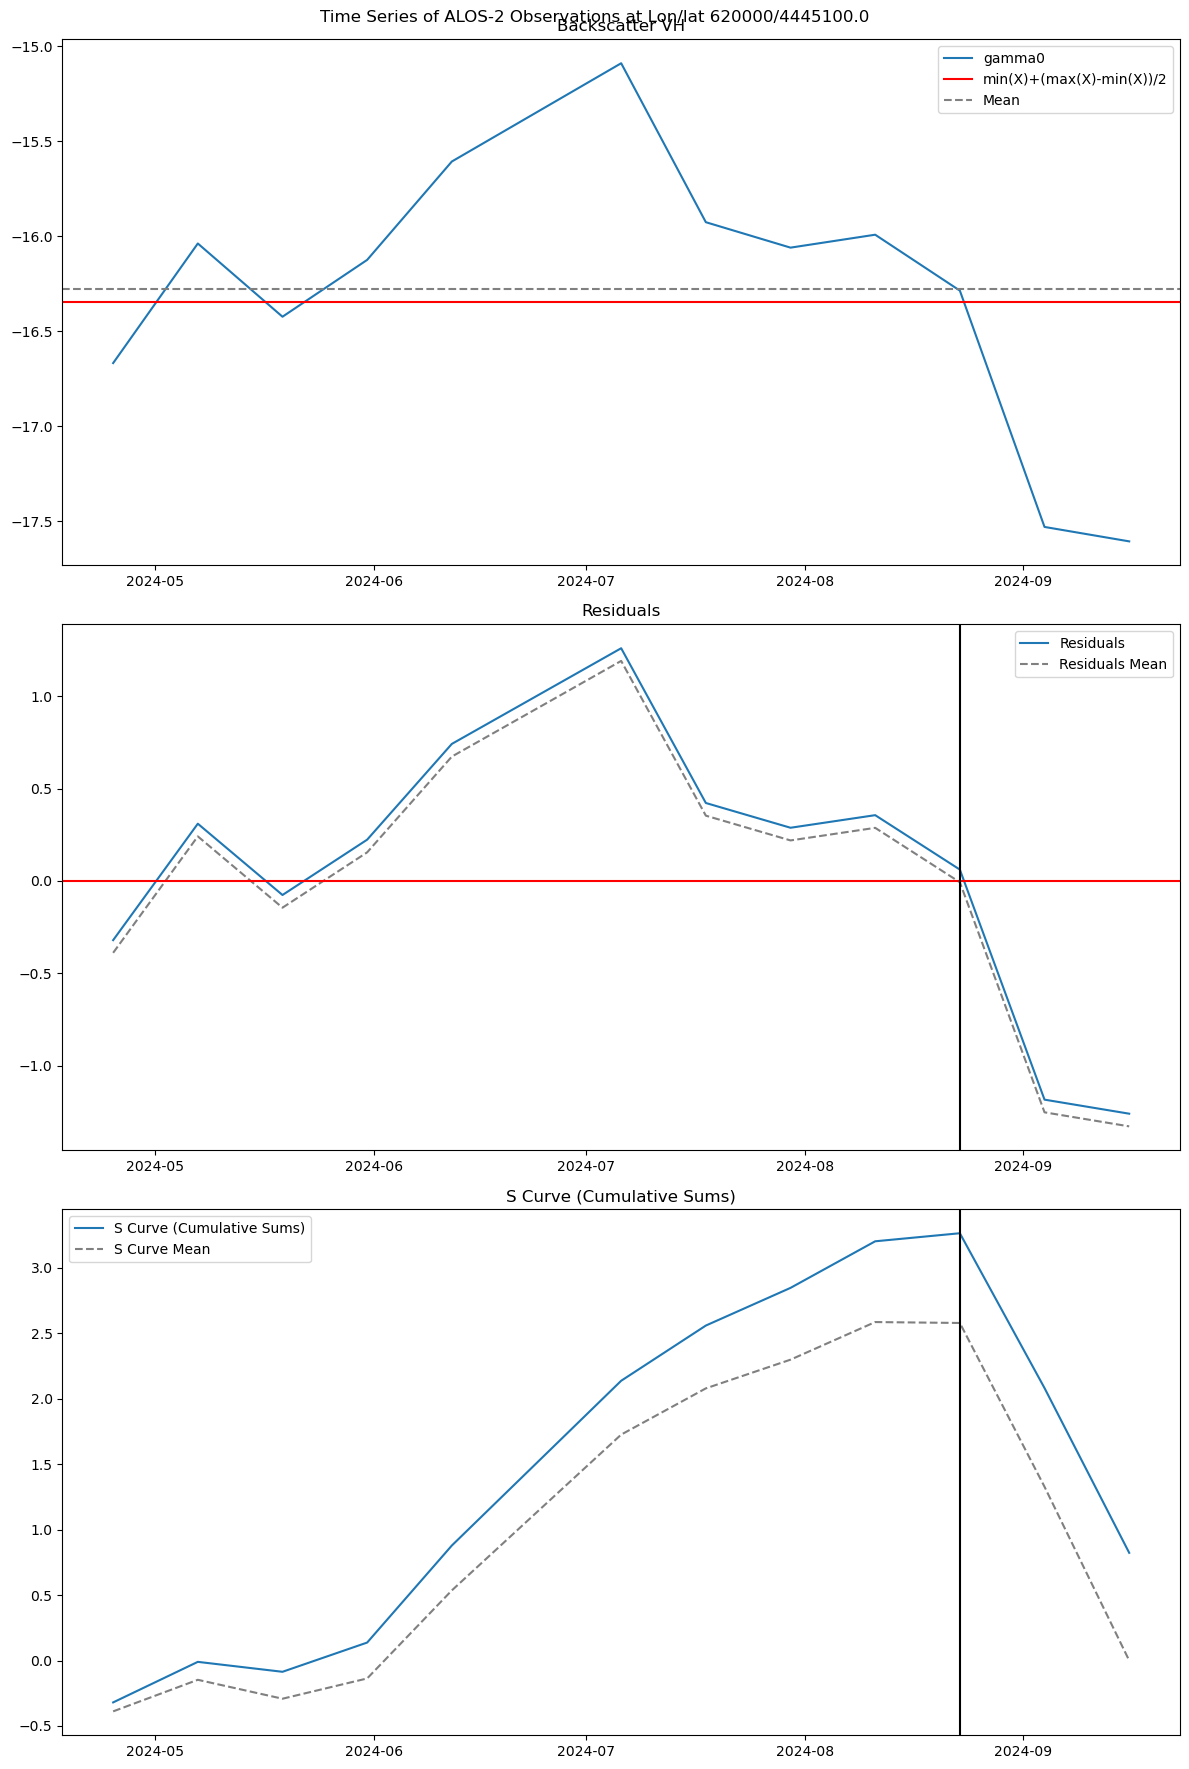

In [33]:
# Disturbance event in late 2020
x, y = 620000, (4390215.0 + 4499985.0)/2
hvp = single_point_CP_vis(X, x, y, polarization)

<a id="FIG_12"></a>

Figure 12: Forest Disturbance event in late 2020 towards the end of the observed time series. The mean estimate of the time series backscatter (gray dashed line) is very different from the geometric mean estimate between max(X) and min(X). The latter is used to calculate the residuals R (center) and S curve (left) shown in blue lines as opposed to the mean derived R and S values shown in the gray lines. The detected change point location is indication by the vertical black line.

The comparison of Figures 11 and 12 shows that the computation of the residuals against the geometric mean of max(X) and min(X) as advantageous as the maxima of the S curve where change points are detected have similar magnitude in similar drop in backscatter scenarios.

[back to TOC](#TOC)

#### Spatial application of change point analysis

We now apply the algorithm of change point detection from cumulative sum analysis to the entire image subset $X$.

The residuals $R_i$ of the time series against the mean are computed as


\begin{align}
R_i = X_i - \overline{X_g}\label{eq8b.}\tag{8b.}
\end{align}

<a id="FIG_13"></a>

In [30]:
Xmean_maxmin = ( X.max(dim='time') + X.min(dim='time') ) / 2.
Xmean_maxmin

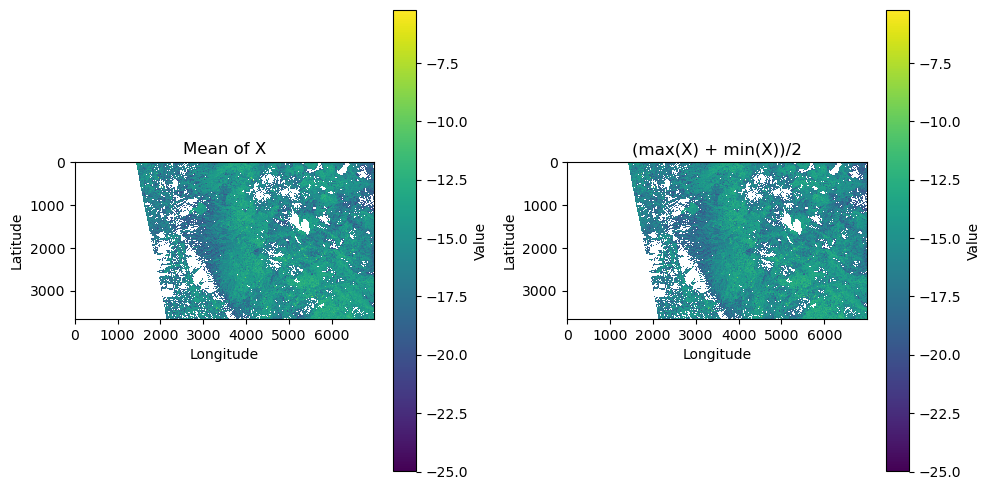

In [36]:

plt.figure(figsize=(10, 5))
if scale_type == 'db':
    vmin = -25
    vmax = 10 * np.log10(0.3)
else:
    vmin = 0
    vmax = 0.3

# Plot Mean of X
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(X.mean(dim='time').sel(polarization='VH').values), 
           cmap='viridis', 
           interpolation='nearest',
           vmin=vmin, vmax=vmax)

plt.colorbar(label='Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean of X')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(Xmean_maxmin.sel(polarization='VH').values),
           cmap='viridis',
           interpolation='nearest',
           vmin=vmin, vmax=vmax)

plt.colorbar(label='Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('(max(X) + min(X))/2')

plt.tight_layout()
plt.show()

*Figure 13: Comparison of the reference values for residual calculation. Left, mean of X according to (8). Right, accounting for max(X) and min(X) according to (8a).*

In [37]:
R = X - Xmean_maxmin

On the time series of the residuals $R_i$ we compute the time series of the cumulative sum of the residuals, $S_i$

\begin{align}
S_i = S_{i-1} + R_i \label{eq9.}\tag{9.}
\end{align}

  with $i=1,...,n$ and $S_0=0$

In [38]:
S = R.cumsum(dim='time')

An estimator for the magnitude of change is given as the difference between the maximum and minimum value of S as

\begin{align}
S_{DIFF} = max(S) - min(S)\label{eq10.}\tag{10.}
\end{align}

<a id="FIG_14"></a>

In [49]:
Sdiff = S.max(dim='time') - S.min(dim='time')
Sdiff = Sdiff.where(Sdiff > 0)
Sdiff = Sdiff.where(S.max(dim='time')>0)  # Only care for positive values in Smax

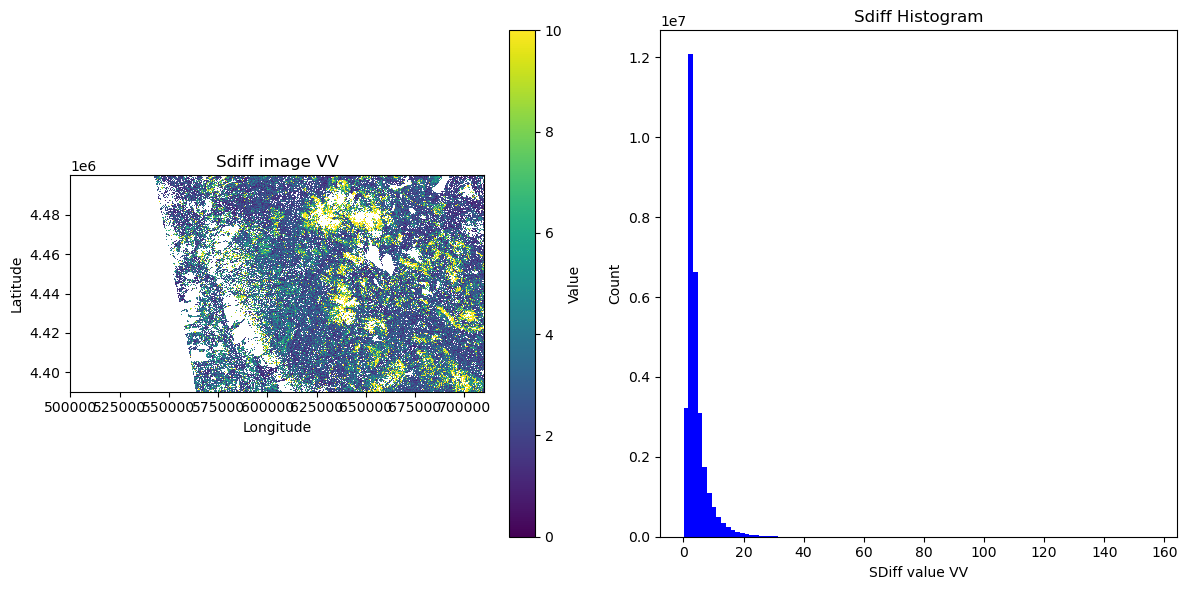

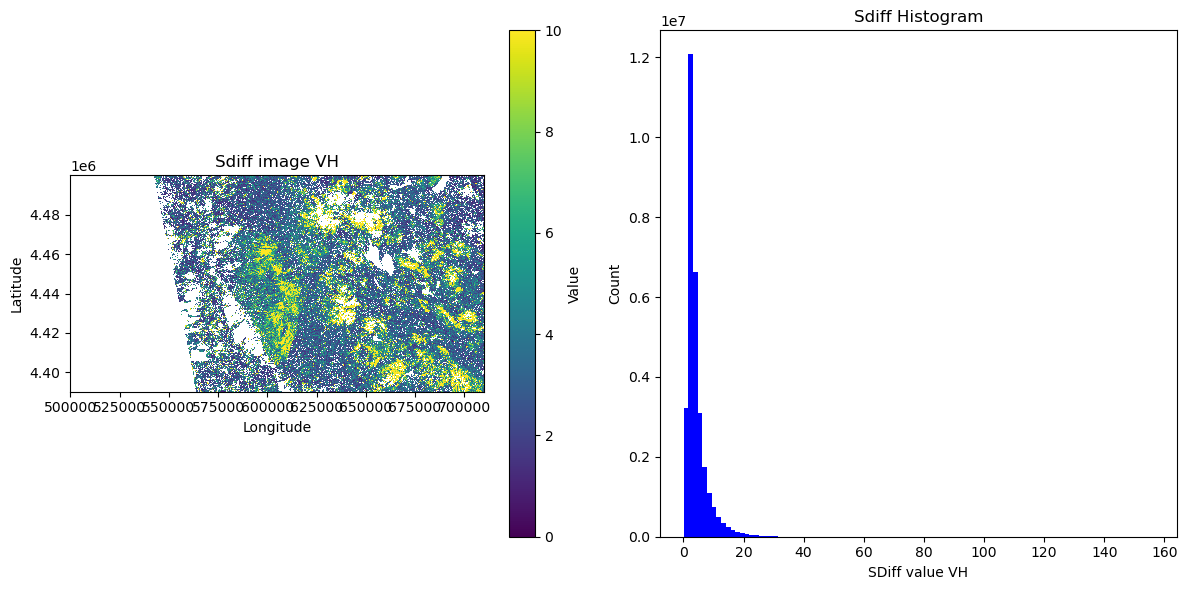

In [56]:
# Assuming Sdiff is your xarray DataArray
title_image = 'Sdiff image'
title_hist = 'Sdiff Histogram'

for polarization in polarizations:
    # Create the figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Sdiff image
    im = axes[0].imshow(np.squeeze(Sdiff.sel(polarization=polarization).values), 
                        cmap='viridis', 
                        vmin=0, vmax=10, 
                        extent=[Sdiff.x.min(), Sdiff.x.max(), Sdiff.y.min(), Sdiff.y.max()],
                    interpolation='nearest')
    axes[0].set_title(f'{title_image} {polarization}')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    plt.colorbar(im, ax=axes[0], label='Value')

    # Plot Sdiff histogram
    axes[1].hist(Sdiff.values.flatten(), bins=100, color='blue')
    axes[1].set_title(title_hist)
    axes[1].set_xlabel(f'SDiff value {polarization}')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

*Figure 14: $S_{DIFF}$ image (left) and its histogram (right).*

[back to TOC](#TOC)

#### Masking the data for further analysis based on $S_{DIFF}$ thresholding

Because we applied a forest mask to our subsetted data stack, we can determine a threshold for disturbance candidates with an  additional mask under which we would consider change points. This helps in data reduction of subsequent analysis, e.g. to reduce the amount of bootstraps over the entire image space.

 - We can pick a threshold from the interactive plot. Programmatically we could set a threshold as a multiple of the standard deviation of the mean in the SDiff pdf (which at its low end approaches Gaussian Distribution:

\begin{align}
thres = \overline{S_{Diff}} + x * \sigma_{S_{Diff}}
\end{align}

with 
$x$  factor for $\sigma$ multiplication from the mean.

- Alternatively, we might be better off using a threshold based on percentile, let's say we want to find a threshold value above which we have the highest 15% of the data

In [57]:
quantile=85
#arr = Sdiff.values.flatten()
dthres = np.nanpercentile(Sdiff.values.flatten(),quantile)
print(f'Setting the threshold for SDiff based on the {quantile}th percentile to: {dthres:.3f}')

Setting the threshold for SDiff based on the 85th percentile to: 6.858


In [58]:
dmask = Sdiff > dthres 
Sdiff_mask = Sdiff.where(dmask)

In [59]:
polarization

'VH'

<a id="FIG_15"></a>

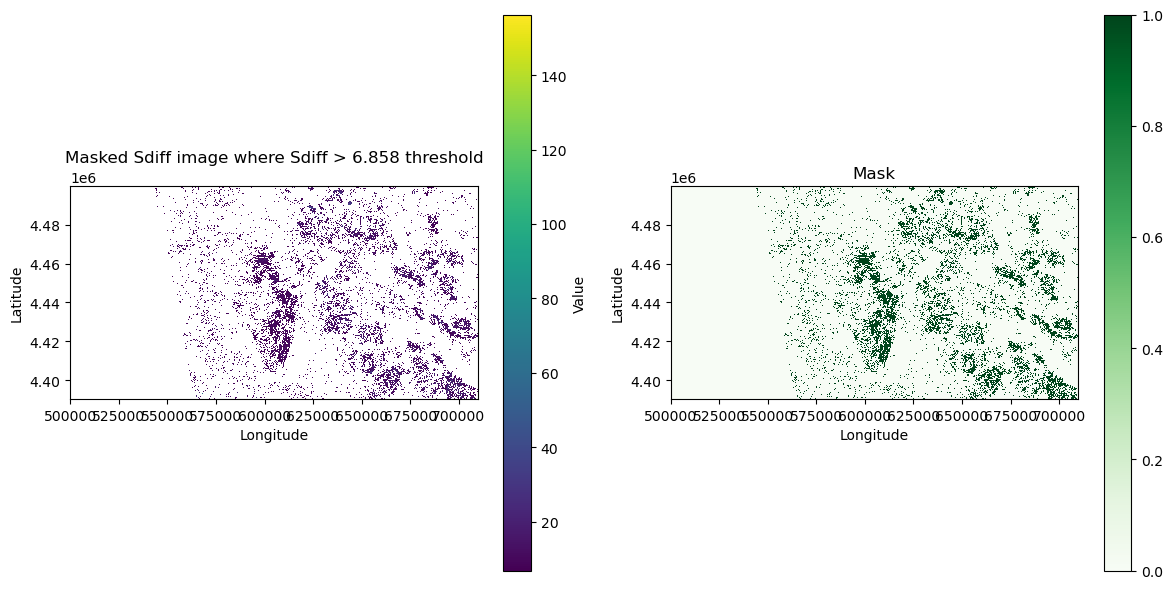

In [60]:
title_image = f'Masked Sdiff image where Sdiff > {dthres:.3f} threshold'

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Sdiff image
im1 = axes[0].imshow(np.squeeze(Sdiff_mask.sel(polarization=polarization).values),
                     interpolation='nearest',
                     cmap='viridis',
                     extent=[Sdiff.x.min(), Sdiff.x.max(), Sdiff.y.min(), Sdiff.y.max()])
axes[0].set_title(title_image)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0], label='Value')

# Plot dmask image
im2 = axes[1].imshow(np.squeeze(dmask.sel(polarization=polarization).values), interpolation='nearest', cmap='Greens', extent=[dmask.x.min(), dmask.x.max(), dmask.y.min(), dmask.y.max()])
axes[1].set_title('Mask')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[1], label='')

plt.tight_layout()
plt.show()


Figure 15: $S_{DIFF}$ image masked by the  percentile threshold. I.e. the remaining pixels for further analysis constitute the top 15% values. Main purpose for further thresholding is data reduction for compute intensive analysis.

#### Bootstrapping the cumulative sums by randomly reordering the time series

We can determine if an identified change point is indeed a valid detection by randomly reordring the time series and comparing the various S curves. During bootstrapping we count how many times the $S_{DIFF}$ values are greater than $S_{{DIFF}_{random}}$ of the identified change point. A confindence level $CL$ is computed as

\begin{align}
CL = \frac{N_{GT}}{N_{bootstraps}}\label{eq12.}\tag{12.}
\end{align}

with 

- $N_{GT}$    Number of times $S_{DIFF}$ > $S_{{DIFF}_{random}}$  
- $N_{bootstraps}$    Number of bootstraps randomizing $R$ in the time dimension


In [79]:
qmetric_residuals = R.copy() #.sel(polarization=polarization)

In [62]:
# dmask = dmask.sel(polarization=polarization)

In [80]:
qmetric_residuals = qmetric_residuals.where(dmask)

In [87]:
S_masked=S.where(dmask)
Smax_masked=S_masked.max('time')
Smin_masked=S_masked.min('time')
SDiff_masked=Smax_masked - Smin_masked

In [89]:
# to keep track of the maxium Sdiff of the bootstrapped sample:
Sdiff_random_max = qmetric_residuals.mean('time').copy() 
# to compute the Sdiff sums of the bootstrapped sample:
Sdiff_random_sum = qmetric_residuals.mean('time').copy() 
# to keep track of the count of the bootstrapped sample
image_shape = (qmetric_residuals.sizes['x'], qmetric_residuals.sizes['y'])

n_Sdiff_gt_Sdiff_random = np.ma.zeros_like(SDiff_masked) #((1, image_shape[1] ,image_shape[0]))

In [83]:
image_shape = (qmetric_residuals.sizes['x'], qmetric_residuals.sizes['y'])
print(f"Image shape (x, y): {image_shape}")


Image shape (x, y): (6994, 3660)


In [84]:
# Set the number of bootstraps to > 100, for demonstration purposes with start with 10
n_bootstraps=100
if develop_run:
    n_bootstraps=1
print(f'Number of bootstraps in the trial run {n_bootstraps}')

Number of bootstraps in the trial run 100


In [90]:

Sdiff_random_sum = 0  # Initialize Sdiff_random_sum
n_Sdiff_gt_Sdiff_random = np.zeros_like(SDiff_masked)  # Initialize the counter array

for i in range(n_bootstraps):
    # Shuffle the time axis index to randomize the masked array
    permutation = np.random.permutation(len(qmetric_residuals['time']))
    Srandom = qmetric_residuals.isel(time=permutation).cumsum('time')  # Apply permutation
    Srandom = Srandom.where(dmask)  # Apply mask

    # Calculate the max and min over time
    Srandom_max = Srandom.max('time')
    Srandom_min = Srandom.min('time')
    Sdiff_random = Srandom_max - Srandom_min
    
    Sdiff_random_sum += Sdiff_random  # Accumulate the Sdiff_random

    # Mask where Sdiff_random is greater than Sdiff_random_max
    gtmask = Sdiff_random > Sdiff_random_max

    # Align the arrays for the where operation
    Sdiff_random_aligned = Sdiff_random.broadcast_like(Sdiff_random_max)
    Sdiff_random_max = xr.where(gtmask, Sdiff_random_aligned, Sdiff_random_max)

    # Update n_Sdiff_gt_Sdiff_random where SDiff_masked is greater than Sdiff_random
    gt_Sdiff_mask = SDiff_masked > Sdiff_random
    n_Sdiff_gt_Sdiff_random += gt_Sdiff_mask.astype(int)  # Increment counter


In [91]:
qmetric_residuals

<xarray.DataArray 'band_data' (polarization: 2, time: 12, band: 1, y: 3660,
                               x: 6994)> Size: 2GB
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
...
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * polarization  (polarization) object 16B 'VV' 'VH'
  * time          (time) datetime64[ns] 96B 2024-04-25 2024-05-07 ... 2024-09-16
  * band          (band) int64 8B 1
  * x             (x) float64 56kB 5e+05 5e+05 5.001e+05 ... 7.098e+05 7.098e+05
  * y             (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref   int64 8B 0

In [174]:
# # to compute the Sdiff sums of the bootstrapped sample:
# SDiff_masked_pol = SDiff_masked.sel(polarization=polarization)
# for i in range(n_bootstraps):
#     # For efficiency, we shuffle the time axis index and use that 
#     #to randomize the masked array
#     permutation=np.random.permutation(len(qmetric_residuals))
#     Srandom = qmetric_residuals[permutation].cumsum('time')
#     Srandom = Srandom.where(dmask)
#     Srandom_max=Srandom.max('time')
#     Srandom_min=Srandom.min('time')
#     Sdiff_random=Srandom_max - Srandom_min
    
#     Sdiff_random_sum += Sdiff_random
#     # Mask where Sdiff_random is greater than Sdiff_random_max
#     gtmask=np.ma.greater(Sdiff_random,Sdiff_random_max).data
#     Sdiff_random_max.where(gtmask,Sdiff_random.where(np.ma.greater(Sdiff_random,Sdiff_random_max).data).values)
#     n_Sdiff_gt_Sdiff_random[np.ma.greater(SDiff_masked.sel(polarization=polarization), Sdiff_random)] += 1

In [92]:
print(n_Sdiff_gt_Sdiff_random.shape)
print(SDiff_masked.sel(polarization=polarization).shape)
print(Sdiff_random.shape)

(2, 1, 3660, 6994)
(1, 3660, 6994)
(2, 1, 3660, 6994)


In [97]:
CL = n_Sdiff_gt_Sdiff_random/n_bootstraps
CL

<xarray.DataArray 'band_data' (polarization: 2, band: 1, y: 3660, x: 6994)> Size: 205MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)
Coordinates:
  * polarization  (polarization) object 16B 'VV' 'VH'
  * band          (band) int64 8B 1
  * x             (x) float64 56kB 5e+05 5e+05 5.001e+05 ... 7.098e+05 7.098e+05
  * y             (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref   int64 8B 0

After the bootstrap run, we set and apply a threshold for the confidence level CL. The most conservative threshold is 1, i.e., the idenified change point's $S_{DIFF}$ value exceeded 100% of the bootstrapped randomized $S_{DIFF_{random}}$ 

In [94]:
cl_thres=.98
print(f'Chosen confidence level threshold:   CL={cl_thres*100}%')

Chosen confidence level threshold:   CL=98.0%


In [98]:
# Apply the threshold to the data stacks 
CL_da = SDiff_masked #.sel(polarization=polarization).copy()
CL_da.data = CL
CL_da = CL_da.where(dmask)
CL_da_mask= CL_da >=cl_thres
CL_da_invalid=CL_da<cl_thres
CL_da_masked = CL_da.copy()
CL_da_masked = CL_da_masked.where(CL_da_mask)

<a id="FIG_16"></a>

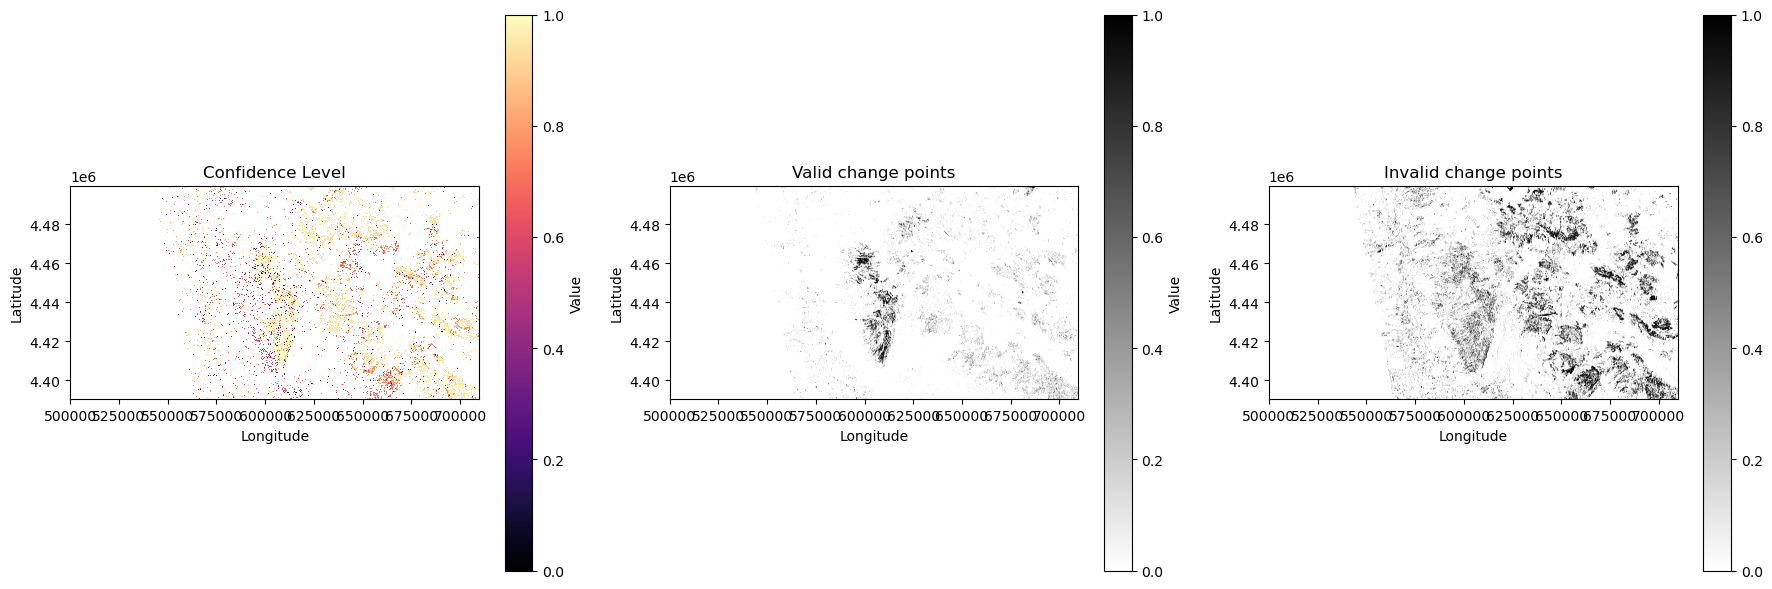

In [101]:

# Assuming CL_da, CL_da_mask, and CL_da_invalid are your xarray DataArrays
title1 = 'Confidence Level'
title2 = 'Valid change points'
title3 = 'Invalid change points'

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Confidence Level image
im1 = axes[0].imshow(np.squeeze(CL_da.sel(polarization='VV').values), cmap='magma',
                     extent=[CL_da.x.min(), CL_da.x.max(), CL_da.y.min(), CL_da.y.max()],
                    interpolation='nearest')
axes[0].set_title(title1)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0], label='Value')

# Plot Valid change points image
im2 = axes[1].imshow(np.squeeze(CL_da_mask.sel(polarization='VV').values), cmap='binary', extent=[CL_da_mask.x.min(), CL_da_mask.x.max(), CL_da_mask.y.min(), CL_da_mask.y.max()])
axes[1].set_title(title2)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[1], label='Value')

# Plot Invalid change points image
im3 = axes[2].imshow(np.squeeze(CL_da_invalid.sel(polarization='VV').values),
                     cmap='binary', extent=[CL_da_invalid.x.min(), CL_da_invalid.x.max(), CL_da_invalid.y.min(), CL_da_invalid.y.max()])
axes[2].set_title(title3)
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
plt.colorbar(im3, ax=axes[2], label='')

plt.tight_layout()
plt.show()

In [102]:
# Let's apply the valid mask to Sdiff
Sdiff = Sdiff.where(CL_da_mask)

Figure 16: Confidence level and derived masks after bootstrapping the process of change point detection. Left: Confidence Level. Center: Valid change points. Right: Invalid change points.

[back to TOC](#TOC)


#### Linking plots to show S Curves

We can visualize the S curves to get a sense for the algorithm to work.

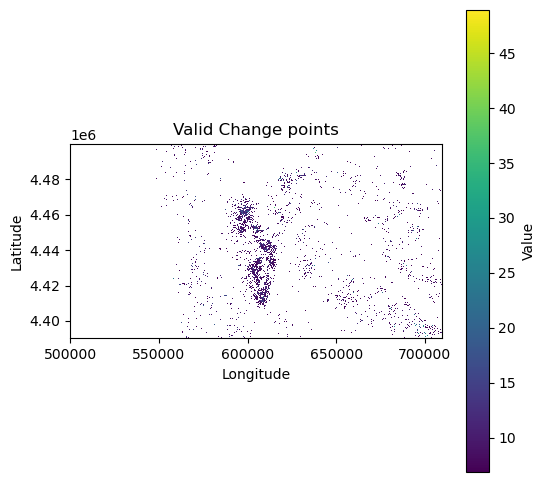

In [103]:
title = 'Valid Change points'

# Create the figure
plt.figure(figsize=(6, 6))

# Plot the image
plt.imshow(np.squeeze(Sdiff.sel(polarization=polarization).values),
           cmap='viridis',
           extent=[Sdiff.x.min(), Sdiff.x.max(), Sdiff.y.min(), Sdiff.y.max()],
          interpolation='nearest')
plt.title(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Value')

plt.show()

In [60]:
#stream.clear()

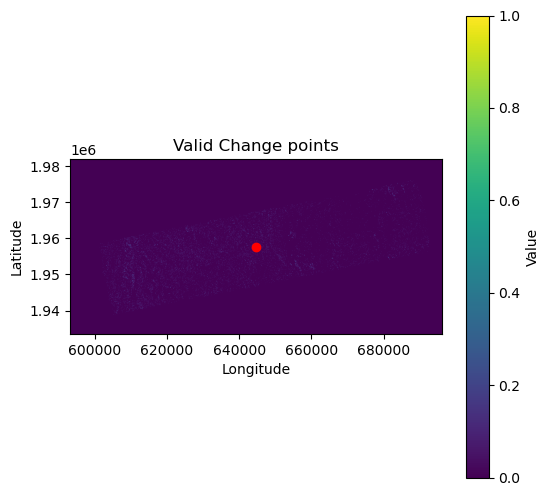

In [192]:
x0 = float(CL_da_mask.x.median())
y0 = float(CL_da_mask.y.median())
title = 'Valid Change points'

# Create the figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the image
im = ax.imshow(np.squeeze(CL_da_mask.values), cmap='viridis', extent=[CL_da_mask.x.min(), CL_da_mask.x.max(), CL_da_mask.y.min(), CL_da_mask.y.max()])
ax.set_title(title)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.colorbar(im, ax=ax, label='Value')

# Initial tap position
x0 = float(CL_da_mask.x.median())
y0 = float(CL_da_mask.y.median())

# Display the initial tap position
tap_marker, = ax.plot(x0, y0, 'ro')  # Initial marker at median position

# Function to handle click events
def on_click(event):
    if event.inaxes == ax:
        tap_marker.set_data(event.xdata, event.ydata)
        fig.canvas.draw()
        print(f"Tapped coordinates: x={event.xdata}, y={event.ydata}")

# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

In [62]:
from numpy import log10
ylim=(S_masked.min().values*0.9,S_masked.max().values*1.1)
def timeseries(x,y):
    title=f'x/y= {x:.2f} {y:.2f}'
    scurve=S_masked.sel(x=x,y=y,method='nearest')
    return scurve.hvplot('time',ylim=ylim,label='CumSum Curve',legend='left',ylabel='Cumulative Sum S',xlabel='Date',title=title)
    # return hv.Overlay(hvlist).opts(show_legend=True,legend_position='right',title=title)

<a id="FIG_17"></a>

In [63]:
pn.Column(
    pn.Row(image),
    pn.bind(timeseries, x=stream.param.x, y=stream.param.y)
)

Column
    [0] Row
        [0] HoloViews(DynamicMap)
    [1] ParamFunction(function)

Figure 17: Interactive Visualization of the S curves at the detected change points. 

#### Determination of change dates

As can be seen from the exploaration of the S curves, the location of the changepoint in the time series is to be taken into consideration. Everything else being equal, backscatter drop early or late in a time series will have lower $S_{DIFF}$ values than the $S_{DIFF}$ value in the center of a time series. At any point in time larger  $S_{DIFF}$ values are indicative of stronger change compared to lower $S_{DIFF}$ values observed at the same point in time.

A candidate change point is identified from the $S$ curve at the time where $S_{MAX}$ is found:

\begin{align}
T_{{CP}_{before}} = T(S_i = S_{MAX})\label{eq11.}\tag{11.}
\end{align}

with

- $T_{{CP}_{before}}$ Timestamp of last observation before change
- $S_i$    Cumulative Sum of R with $i=1,...n$
- $n$      Number of observations in the time series 

The first observation after change occured ($T_{{CP}_{after}}$) is then found as the first observation in the time series following $T_{{CP}_{before}}$.

In [193]:
# Determine the location of the changepoint in the time series with argmax

CP_loc = S.argmax(dim='time',skipna=True,keep_attrs=True)
CP_loc = CP_loc.where(CL_da_mask)

In [194]:
CP_loc_2019 = CP_loc.where(CP_loc>=20).where(CP_loc<=34)
CP_loc_2020 = CP_loc.where(CP_loc>=35)


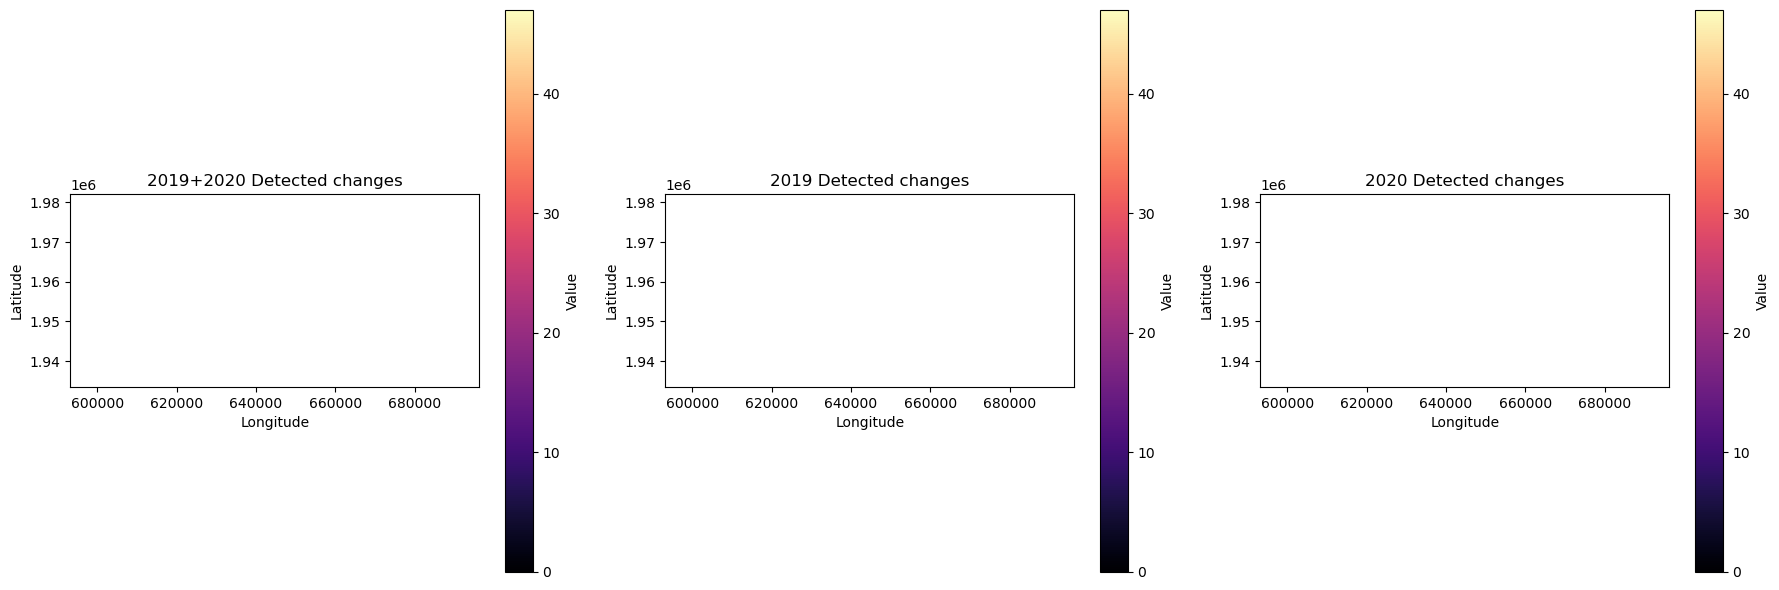

In [199]:
# Assuming CP_loc, CP_loc_2019, and CP_loc_2020 are your xarray DataArrays
title1 = '2019+2020 Detected changes'
title2 = '2019 Detected changes'
title3 = '2020 Detected changes'
import contextily as ctx

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 2019+2020 Detected changes
im1 = axes[0].imshow(np.squeeze(CP_loc.sel(polarization=polarization).values), cmap='magma', extent=[CP_loc.x.min(), CP_loc.x.max(), CP_loc.y.min(), CP_loc.y.max()], vmin=0, vmax=47)
axes[0].set_title(title1)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
# ctx.add_basemap(axes[0], crs='EPSG:4326', source=ctx.providers.Esri.WorldImagery)
plt.colorbar(im1, ax=axes[0], label='Value')

# Plot 2019 Detected changes
im2 = axes[1].imshow(np.squeeze(CP_loc_2019.sel(polarization=polarization).values), cmap='magma', extent=[CP_loc_2019.x.min(), CP_loc_2019.x.max(), CP_loc_2019.y.min(), CP_loc_2019.y.max()], vmin=0, vmax=47)
axes[1].set_title(title2)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
# ctx.add_basemap(axes[1], crs='EPSG:4326', source=ctx.providers.Esri.WorldImagery)
plt.colorbar(im2, ax=axes[1], label='Value')

# Plot 2020 Detected changes
im3 = axes[2].imshow(np.squeeze(CP_loc_2020.sel(polarization=polarization).values), cmap='magma', extent=[CP_loc_2020.x.min(), CP_loc_2020.x.max(), CP_loc_2020.y.min(), CP_loc_2020.y.max()], vmin=0, vmax=47)
axes[2].set_title(title3)
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
# ctx.add_basemap(axes[2], crs='EPSG:4326', source=ctx.providers.Esri.WorldImagery)
plt.colorbar(im3, ax=axes[2], label='Value')

plt.tight_layout()
plt.show()

<a id="FIG_18"></a>

:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .Tiles.I :Tiles   [x,y]
         .Image.I :Image   [x,y]   (A2_192_3800_HV_pwr_mtfil)
   .DynamicMap.II  :DynamicMap   []
      :Overlay
         .Tiles.I :Tiles   [x,y]
         .Image.I :Image   [x,y]   (A2_192_3800_HV_pwr_mtfil)
   .DynamicMap.III :DynamicMap   []
      :Overlay
         .Tiles.I :Tiles   [x,y]
         .Image.I :Image   [x,y]   (A2_192_3800_HV_pwr_mtfil)

Figure 18: Visualization of change point dates. Displayed are band numbers in the time series data stack. Note that the dates shown are the detected change event or at which point a gradual disturbance event was marked by the cumulative sum change point detection.

[back to TOC](#TOC)

<a id="SEC_4E"></a>
### 4.E Generation of the NISAR disturbance product from the change point data set

We are coarsening the data set to one-hectare cells by applying a count in 5x5 blocks (to get 100x100 sqm from the 20x20 sqm pixels). We do this for the 2019 and 2020 detected changes separately. An intermediate product is the count of 20 m pixels that were detected to change inside a one-hectare pixel. This product is thresholded by a minimum count (default five pixels) to classify a one-hectare pixel as disturbed. The threshold is applied to remove classification noise and can be adapted.   

In [69]:
##########################################################################
# Prepare 2019 and 2020 data for the nisar disturbance products 
##########################################################################
# Making binary changed/not-changed maps
ndp_20_2019 = CP_loc_2019>=0
ndp_20_2020 = CP_loc_2020>=0
ndp_20_2019 = ndp_20_2019.where(ndp_20_2019>0)
ndp_20_2020 = ndp_20_2020.where(ndp_20_2020>0)

In [70]:
ndp_100_2019_count = ndp_20_2019.coarsen(x=5,y=5,boundary='exact',coord_func='median').sum()
ndp_100_2019_count = ndp_100_2019_count.where(ndp_100_2019_count>0)

##### Disturbed pixels count in one-hectare cells 

We coarsen the 20 m resolution data to one-hectare cells and count how many pixels we encounter in each one-hectare cell. By thresholding these 'count' image with the minimum required number of pixels to classify a cell disturbed at hectare scale, we can generate the final NISAR disturbance product (see (15),(16)). This procedure is done for each year of analysis.


<a id="FIG_19"></a>

In [71]:
title='2019 disturbance pixel count at hectare scale'
ndp_100_2019_count_hvp = ndp_100_2019_count.hvplot.image(x='x',y='y',geo=True,rasterize=True,cmap='magma',frame_width=600,
                          xlabel='Longitude',ylabel='Latitude',title=title,tiles='ESRI',colorbar=True)
ndp_100_2019_count_hvp

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (A2_192_3800_HV_pwr_mtfil)

Figure 19: Count of disturbed 20 m pixels in one-hectare cells. Example for year 2019.

In [72]:
pixelthres = 5
ndp_100_2019 = ndp_20_2019.coarsen(x=5,y=5,boundary='exact',coord_func='median').sum()
ndp_100_2019 = ndp_100_2019>=pixelthres
ndp_100_2019 = ndp_100_2019.where(ndp_100_2019 > 0)
ndp_100_2020 = ndp_20_2020.coarsen(x=5,y=5,boundary='exact',coord_func='median').sum()
ndp_100_2020 = ndp_100_2020>=pixelthres
ndp_100_2020 = ndp_100_2020.where(ndp_100_2020 > 0)


In [73]:
title='2019 20m Disturbance product'
ndp_20_2019_hvp = ndp_20_2019.hvplot.image(x='x',y='y',geo=True,rasterize=True,cmap='reds',frame_width=300,
                          xlabel='Longitude',ylabel='Latitude',title=title,tiles='ESRI',colorbar=False)
title='2020 20m Disturbance product'
ndp_20_2020_hvp = ndp_20_2020.hvplot.image(x='x',y='y',geo=True,rasterize=True,cmap='reds',frame_width=300,
                          xlabel='Longitude',ylabel='Latitude',title=title,tiles='ESRI',colorbar=False)
title='2019 100m Disturbance product'
ndp_100_2019_hvp = ndp_100_2019.hvplot.image(x='x',y='y',geo=True,rasterize=True,cmap='reds',frame_width=300,
                          xlabel='Longitude',ylabel='Latitude',title=title,tiles='ESRI',colorbar=False)
title='2020 100m Disturbance product'
ndp_100_2020_hvp = ndp_100_2020.hvplot.image(x='x',y='y',geo=True,rasterize=True,cmap='reds',frame_width=300,
                          xlabel='Longitude',ylabel='Latitude',title=title,tiles='ESRI',colorbar=False)

<a id="FIG_20"></a>